<h1>CADRL Complete Training (IL + RL)</h1>

Import the necessary packages

In [1]:
from jax import random, device_get
import jax.numpy as jnp
import optax
import numpy as np
import time
import matplotlib.pyplot as plt

from socialjym.envs.socialnav import SocialNav
from socialjym.policies.cadrl import CADRL
from socialjym.utils.replay_buffers.uniform_vnet_replay_buffer import UniformVNetReplayBuffer
from socialjym.utils.rollouts.deep_vnet_rollouts import deep_vnet_rl_rollout, deep_vnet_il_rollout
from socialjym.utils.aux_functions import epsilon_scaling_decay, plot_state, plot_trajectory, test_k_trials
from socialjym.utils.rewards.reward1 import generate_reward_done_function

/home/tommaso/PyVenvs/socialjym/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set the training hyperparameters

In [2]:
random_seed = 1
il_training_episodes = 3_000
il_learning_rate = 0.01
il_num_epochs = 50 # Number of epochs to train the model after ending IL
rl_training_episodes = 10_000
rl_learning_rate = 0.001
rl_num_batches = 100 # Number of batches to train the model after each RL episode
batch_size = 100 # Number of experiences to sample from the replay buffer for each model update
epsilon_start = 0.5
epsilon_end = 0.1
epsilon_decay = 4_000
buffer_size = 100_000 # Maximum number of experiences to store in the replay buffer (after exceeding this limit, the oldest experiences are overwritten with new ones)
target_update_interval = 50 # Number of episodes to wait before updating the target network for RL (the one used to compute the target state values)
humans_policy = 'hsfm'
scenario = 'hybrid_scenario'

Set the reward and environment parameters

In [3]:
# Reward function parameters
reward_params = {
    'goal_reward': 1.,
    'collision_penalty': -0.25,
    'discomfort_distance': 0.2,
    'time_limit': 50.,
}

# Initialize reward function
reward_function = generate_reward_done_function(**reward_params)

# Environment parameters
env_params = {
    'robot_radius': 0.3,
    'n_humans': 1,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': False,
    'scenario': scenario,
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}

Initialize environment, robot policy and replay buffer

In [4]:
# Initialize environment
env = SocialNav(**env_params)

# Initialize robot policy and vnet params
policy = CADRL(env.reward_function, dt=env_params['robot_dt'])
initial_vnet_params = policy.model.init(random.key(random_seed), jnp.zeros((policy.vnet_input_size,)))

# Initialize replay buffer
replay_buffer = UniformVNetReplayBuffer(buffer_size, batch_size)

<h2>Imitation Learning</h2>

Initialize the optimizer and the buffer state dictionary (where experiences will be stored)

In [5]:
# Initialize IL optimizer
optimizer = optax.sgd(learning_rate=il_learning_rate, momentum=0.9)

# Initialize buffer state
buffer_state = {
    'vnet_inputs': jnp.empty((buffer_size, env.n_humans, policy.vnet_input_size)),
    'targets': jnp.empty((buffer_size,1)),
}

Set all the parameters for the imitation learning rollout

In [6]:
il_rollout_params = {
    'initial_vnet_params': initial_vnet_params,
    'train_episodes': il_training_episodes,
    'random_seed': random_seed,
    'optimizer': optimizer,
    'buffer_state': buffer_state,
    'current_buffer_size': 0,
    'policy': policy,
    'env': env,
    'replay_buffer': replay_buffer,
    'buffer_size': buffer_size,
    'num_epochs': il_num_epochs,
    'batch_size': batch_size,
    'success_reward': reward_params['goal_reward'],
    'failure_reward': reward_params['collision_penalty']
}

During imitation learning, the robot will move using the same policy used by humans. Let's start the rollout.

In [7]:
il_out = deep_vnet_il_rollout(**il_rollout_params)

Simulating IL episodes...


Running for 3,000 iterations: 100%|██████████| 3000/3000 [00:03<00:00, 757.58it/s]


Buffer size after IL: 100000
Optimizing model on generated experiences for 50 epochs...


Running for 50 iterations: 100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


Now, we save the parameters we are interested in from the rollout output and we plot the discounted return over the IL training episodes and the loss over the optimization epochs.

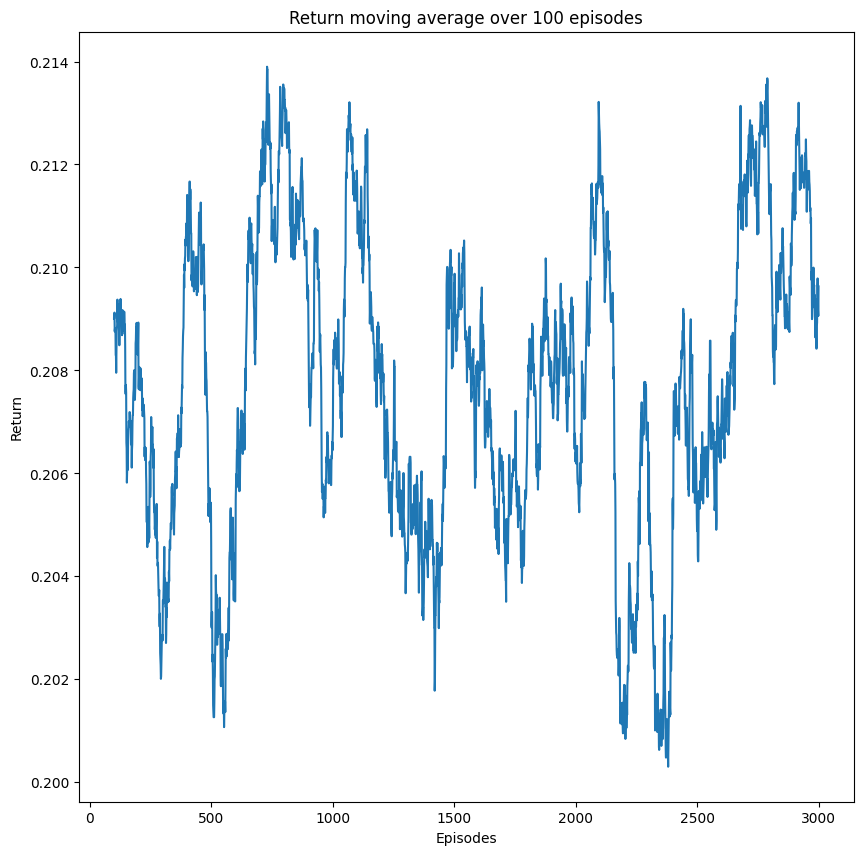

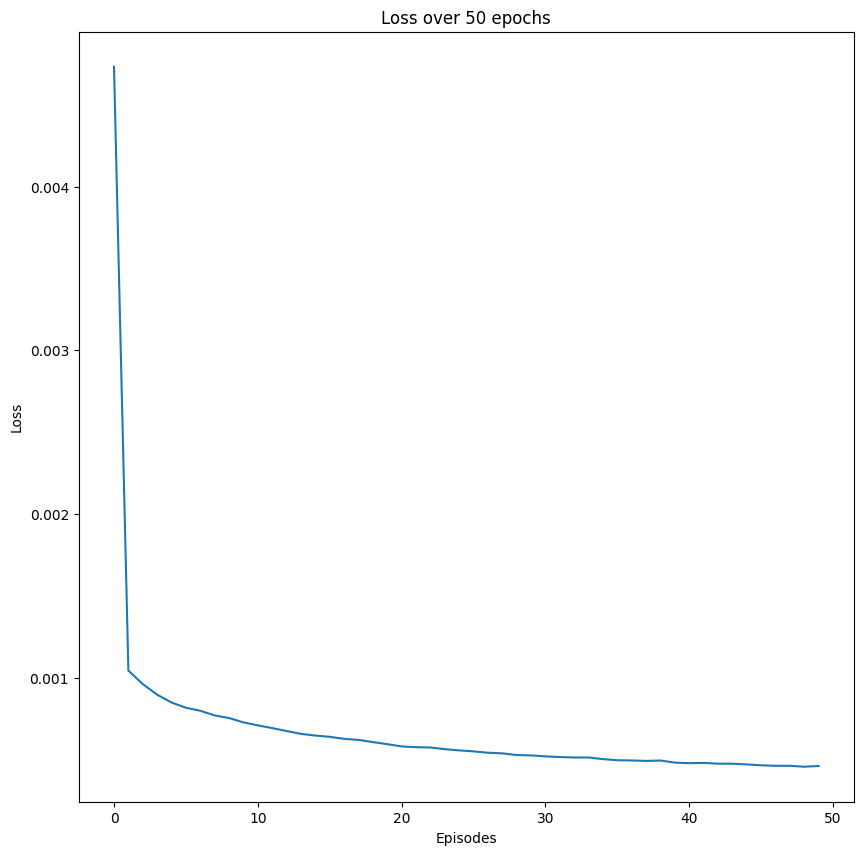

In [8]:
# Save the IL model parameters, buffer state, and keys
il_model_params = il_out['model_params']
reset_key = il_out['reset_key']
policy_key = il_out['policy_key']
buffer_state = il_out['buffer_state']
current_buffer_size = il_out['current_buffer_size']

# Plot the losses and returns
window = 100
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Return', title='Return moving average over {} episodes'.format(window))
ax.plot(np.arange(len(il_out['returns'])-(window-1))+window, jnp.convolve(il_out['returns'], jnp.ones(window,), 'valid') / window)
plt.show()
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Loss', title='Loss over {} epochs'.format(len(il_out['losses'])))
ax.plot(np.arange(len(il_out['losses'])), il_out['losses'])
plt.show()

Let's test the IL trained agent on 1000 unseen trials. The robot is still NOT visible by humans here.

In [9]:
test_k_trials(1000, 2, env, policy, il_model_params, success_reward=reward_params['goal_reward'], failure_reward=reward_params['collision_penalty'])


Executing 1000 tests with 1 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:08<00:00, 121.57it/s]


RESULTS
Success rate: 0.97
Collision rate: 0.00
Timeout rate: 0.03
Average return: 0.15
SPL: 0.77
Average time to goal: 18.55 s
Average path length: 18.48 m
Average speed: 1.00 m/s
Average acceleration: 0.62 m/s^2
Average jerk: 4.53 m/s^3
Average space compliance: 0.97
Average minimum distance to humans: 2.14 m


{'average_acceleration': Array([0.736118  , 0.89475536, 0.3667513 , 0.28450048, 0.80736935,
        1.351286  , 0.47486442, 0.4161926 , 0.6597615 , 0.66991645,
        0.33815655, 1.3297379 , 1.8155656 , 0.3485203 , 0.44869545,
        0.81126153, 0.954731  , 1.2307298 , 0.8174458 , 0.725844  ,
        0.87245005, 0.4640669 , 0.64949155, 0.4482036 , 0.55916107,
        0.70158446, 0.21090844, 0.7837927 , 0.50908613, 0.22863598,
        0.738216  , 1.0044326 , 1.0603515 , 0.41362965, 0.63827413,
        0.62850785, 0.43328375, 0.5475305 , 0.52600867, 0.62482923,
        0.80740637, 0.50923365, 0.47348624, 0.40634355, 0.6880985 ,
        0.49692243, 0.8364866 , 0.5192531 ,        nan, 1.1737326 ,
        0.4072663 , 0.5818209 , 0.66576904, 0.38325512, 0.49222946,
        0.7017296 , 0.9120814 ,        nan, 0.69192857, 0.70398164,
        0.46240222, 0.340832  , 0.55336183, 0.7299676 , 1.3616792 ,
        0.70969075, 0.85853827, 0.7725064 , 0.5176246 , 0.8162412 ,
        0.5555184 , 0.79

<h2>Reinforcement Learning</h2>

Initialize the optimizer and the next rollout parameters. We should start from the model parameters compute after IL.

In [10]:
# Initialize RL optimizer
optimizer = optax.sgd(learning_rate=rl_learning_rate, momentum=0.9)

# Initialize RL rollout params
rl_rollout_params = {
    'initial_vnet_params': il_model_params,
    'train_episodes': rl_training_episodes,
    'random_seed': random_seed,
    'model': policy.model,
    'optimizer': optimizer,
    'buffer_state': buffer_state,
    'current_buffer_size': current_buffer_size,
    'policy': policy,
    'env': env,
    'replay_buffer': replay_buffer,
    'buffer_size': buffer_size,
    'num_batches': rl_num_batches,
    'epsilon_decay_fn': epsilon_scaling_decay,
    'epsilon_start': epsilon_start,
    'epsilon_end': epsilon_end,
    'decay_rate': epsilon_decay,
    'target_update_interval': target_update_interval,
    'success_reward': reward_params['goal_reward'],
    'failure_reward': reward_params['collision_penalty']
}

Let's start the RL rollout.

In [11]:
rl_out = deep_vnet_rl_rollout(**rl_rollout_params)

Running for 10,000 iterations: 100%|██████████| 10000/10000 [13:24<00:00, 12.42it/s]


Save the final model parameters and plot discounted return and loss over the RL training episodes.

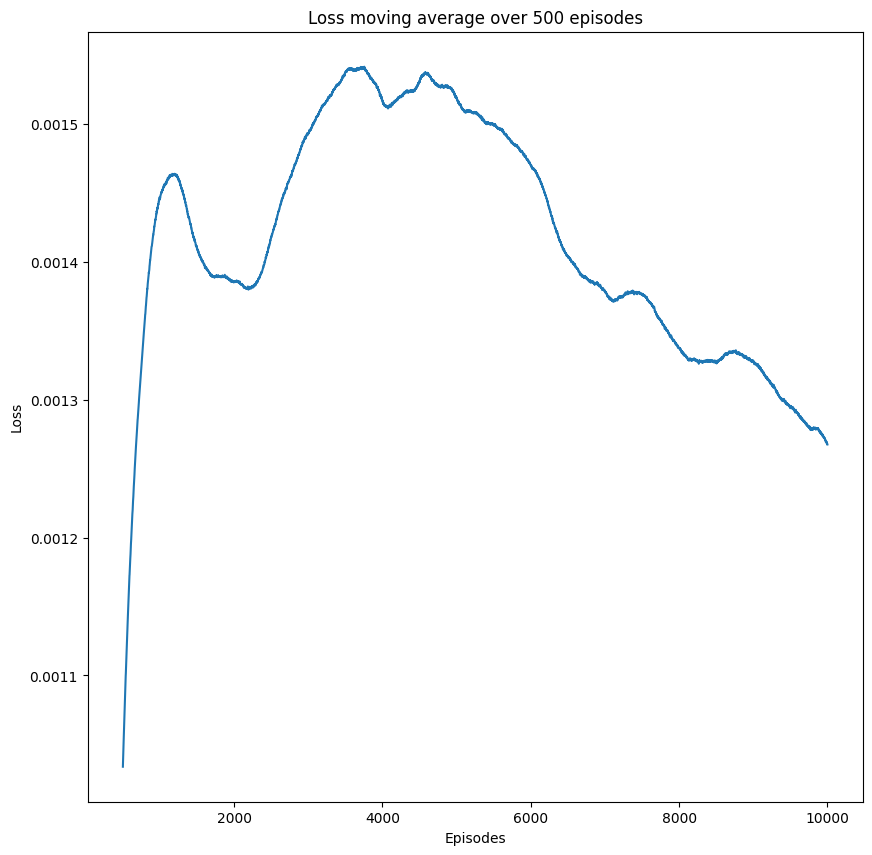

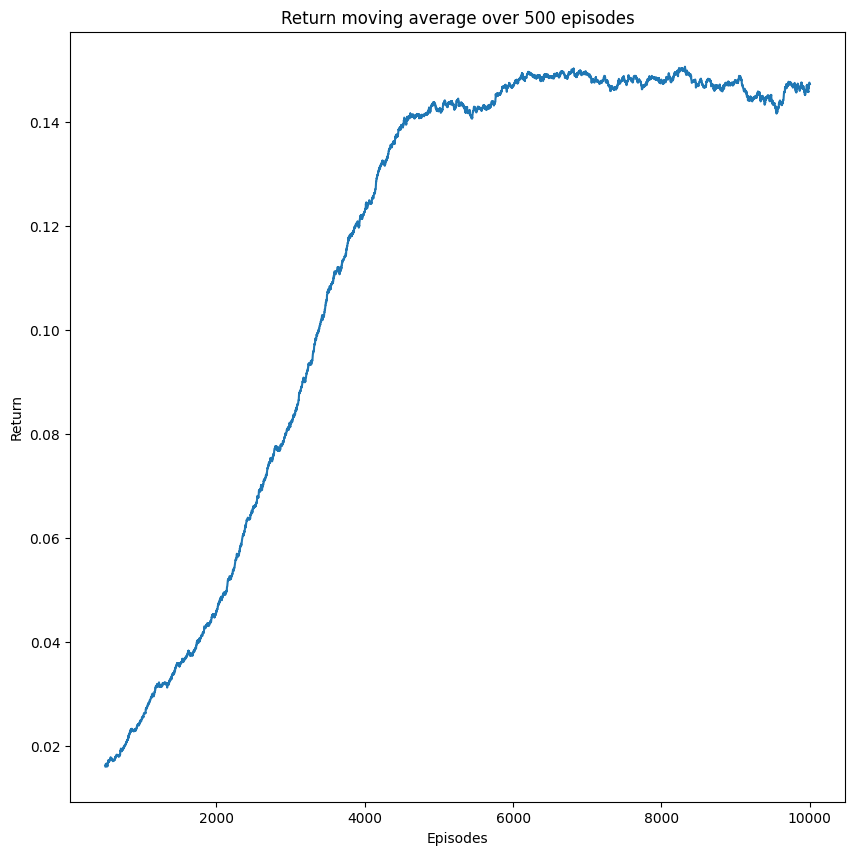

In [12]:
# Save the final model parameters and keys
final_model_params = rl_out['model_params']
reset_key = rl_out['reset_key']
policy_key = rl_out['policy_key']

figure, ax = plt.subplots(figsize=(10,10))
window = 500
ax.plot(np.arange(len(rl_out['losses'])-(window-1))+window, jnp.convolve(rl_out['losses'], jnp.ones(window,), 'valid') / window)
ax.set(xlabel='Episodes', ylabel='Loss', title='Loss moving average over {} episodes'.format(window))
plt.show()
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Return', title='Return moving average over {} episodes'.format(window))
ax.plot(np.arange(len(rl_out['returns'])-(window-1))+window, jnp.convolve(rl_out['returns'], jnp.ones(window,), 'valid') / window)
plt.show()

Let's test the RL trained agent in three environments, with 1, 5 and 10 humans. In all environments the robot is visible.

In [13]:
env_params = {
    'robot_radius': 0.3,
    'n_humans': 1,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': scenario,
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}
env = SocialNav(**env_params)
env5_params = {
    'robot_radius': 0.3,
    'n_humans': 5,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': scenario,
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}
env5 = SocialNav(**env5_params)
env10_params = {
    'robot_radius': 0.3,
    'n_humans': 10,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': scenario,
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}
env10 = SocialNav(**env10_params)
test_k_trials(1000, 3, env, policy, final_model_params, success_reward=reward_params['goal_reward'], failure_reward=reward_params['collision_penalty'])
test_k_trials(1000, 3, env5, policy, final_model_params, success_reward=reward_params['goal_reward'], failure_reward=reward_params['collision_penalty'])
test_k_trials(1000, 3, env10, policy, final_model_params, success_reward=reward_params['goal_reward'], failure_reward=reward_params['collision_penalty'])


Executing 1000 tests with 1 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:07<00:00, 132.82it/s]


RESULTS
Success rate: 0.99
Collision rate: 0.00
Timeout rate: 0.01
Average return: 0.19
SPL: 0.89
Average time to goal: 15.83 s
Average path length: 15.60 m
Average speed: 0.99 m/s
Average acceleration: 0.79 m/s^2
Average jerk: 5.63 m/s^3
Average space compliance: 0.98
Average minimum distance to humans: 1.42 m

Executing 1000 tests with 5 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:44<00:00, 22.46it/s]


RESULTS
Success rate: 0.97
Collision rate: 0.00
Timeout rate: 0.03
Average return: 0.18
SPL: 0.88
Average time to goal: 16.27 s
Average path length: 15.50 m
Average speed: 0.96 m/s
Average acceleration: 0.96 m/s^2
Average jerk: 6.69 m/s^3
Average space compliance: 0.87
Average minimum distance to humans: 0.52 m

Executing 1000 tests with 10 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [01:54<00:00,  8.75it/s]

RESULTS
Success rate: 0.94
Collision rate: 0.00
Timeout rate: 0.06
Average return: 0.15
SPL: 0.82
Average time to goal: 17.55 s
Average path length: 16.31 m
Average speed: 0.94 m/s
Average acceleration: 1.11 m/s^2
Average jerk: 7.71 m/s^3
Average space compliance: 0.78
Average minimum distance to humans: 0.28 m


{'average_acceleration': Array([1.027426  , 1.6553609 , 1.5662647 ,        nan, 1.7844151 ,
        0.9743136 , 0.41102436, 1.2222053 , 0.66139615, 1.3097628 ,
        0.99348533,        nan, 0.9807844 , 1.1298804 , 1.4372671 ,
        1.5921477 , 1.414029  , 0.86903274, 1.559218  , 0.5972593 ,
        1.063868  , 1.4517301 , 0.67899734, 1.2321266 , 0.90601736,
        1.5056213 , 1.473543  , 1.6428133 , 1.291447  , 1.0511029 ,
        1.6724514 , 1.1051744 , 1.1844177 , 0.8991098 , 0.835964  ,
        1.4628122 , 0.7787678 , 1.4406146 , 0.56226563, 1.4841976 ,
        1.2596079 , 1.0850699 , 1.095869  , 0.9420162 , 1.1788498 ,
        1.1508585 , 0.59663725, 1.1209292 , 1.0197928 , 0.78002024,
        0.71703565, 1.085612  , 1.4674842 , 1.1529778 , 1.6162773 ,
        0.89462   , 1.1395849 ,        nan, 1.1511904 , 1.6851242 ,
        1.3515445 , 0.6176395 , 0.95784235, 0.93672067, 0.6243069 ,
        0.5637179 , 1.3566281 , 1.2632917 , 1.2838651 , 1.7640966 ,
        1.1181179 , 1.20

Simulate some episodes using the trained agent.

Episode 0 ended - Execution time 4.22 seconds - Plotting trajectory...


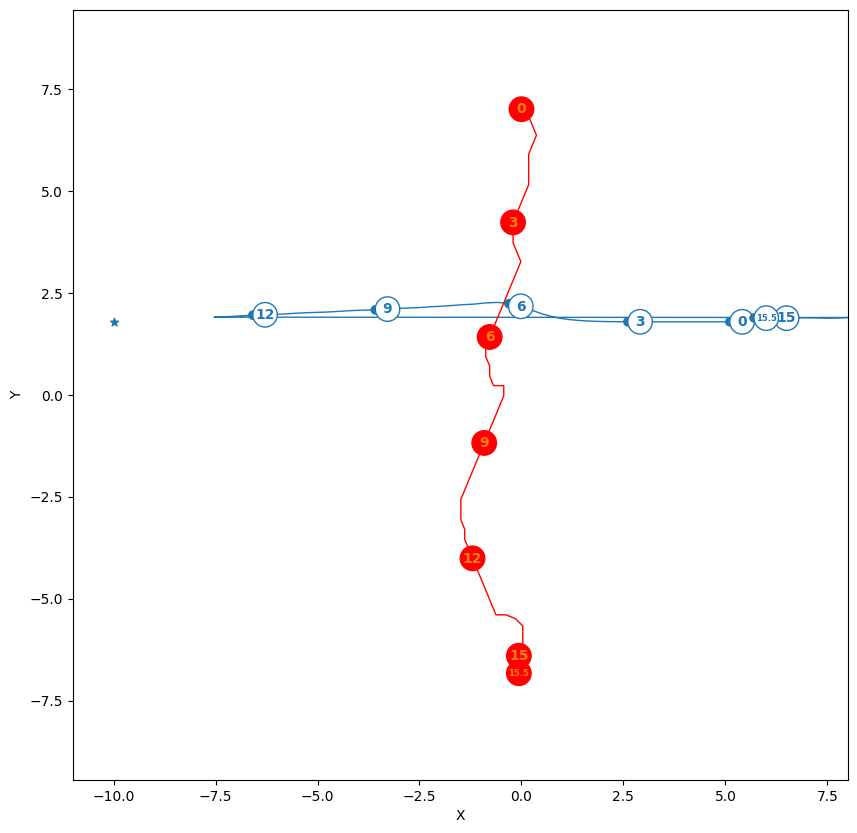

Episode 1 ended - Execution time 0.02 seconds - Plotting trajectory...


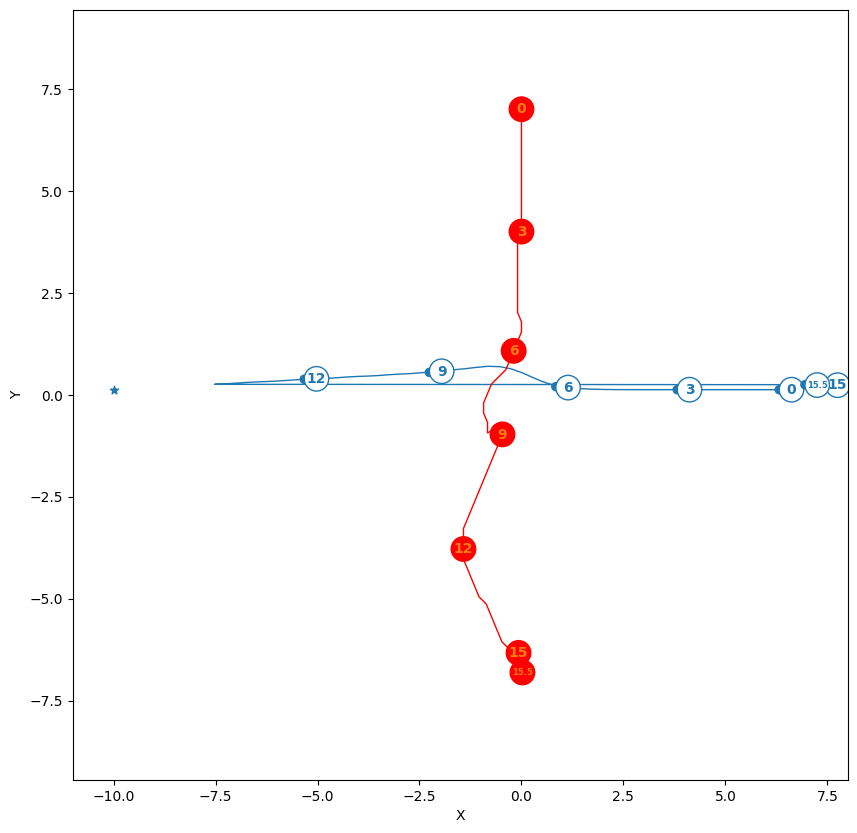

Episode 2 ended - Execution time 0.02 seconds - Plotting trajectory...


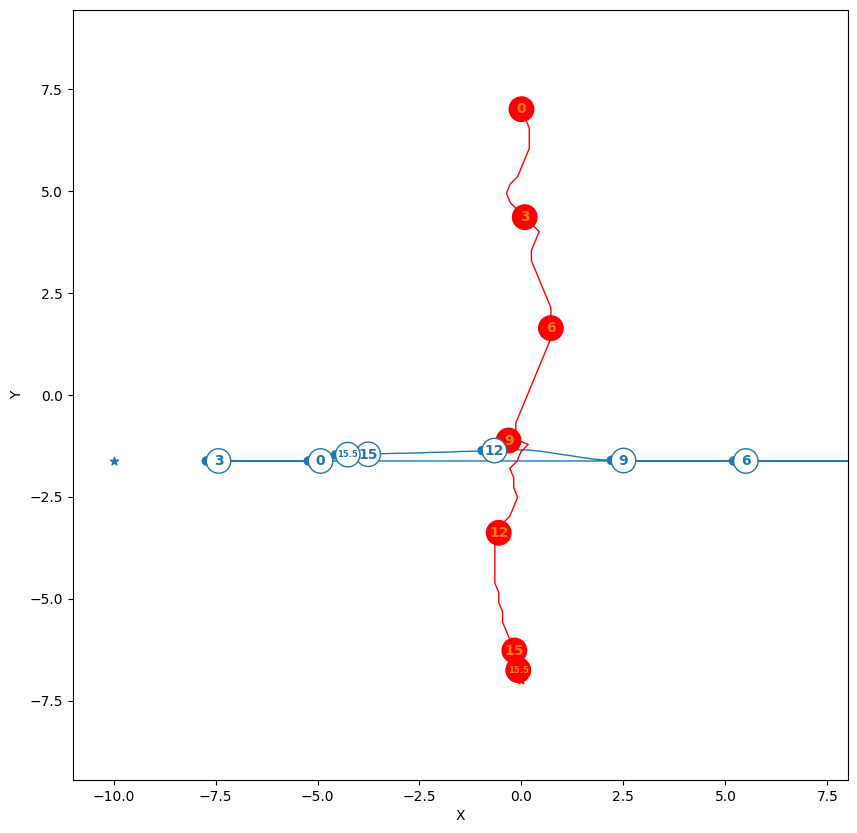

Episode 3 ended - Execution time 0.03 seconds - Plotting trajectory...


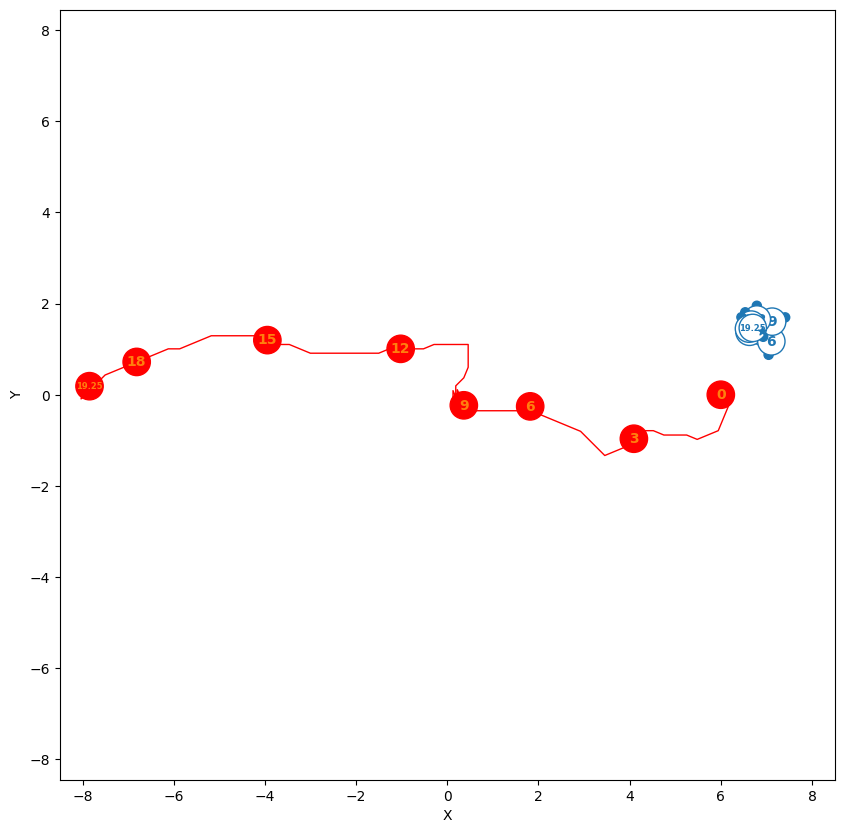

Episode 4 ended - Execution time 0.02 seconds - Plotting trajectory...


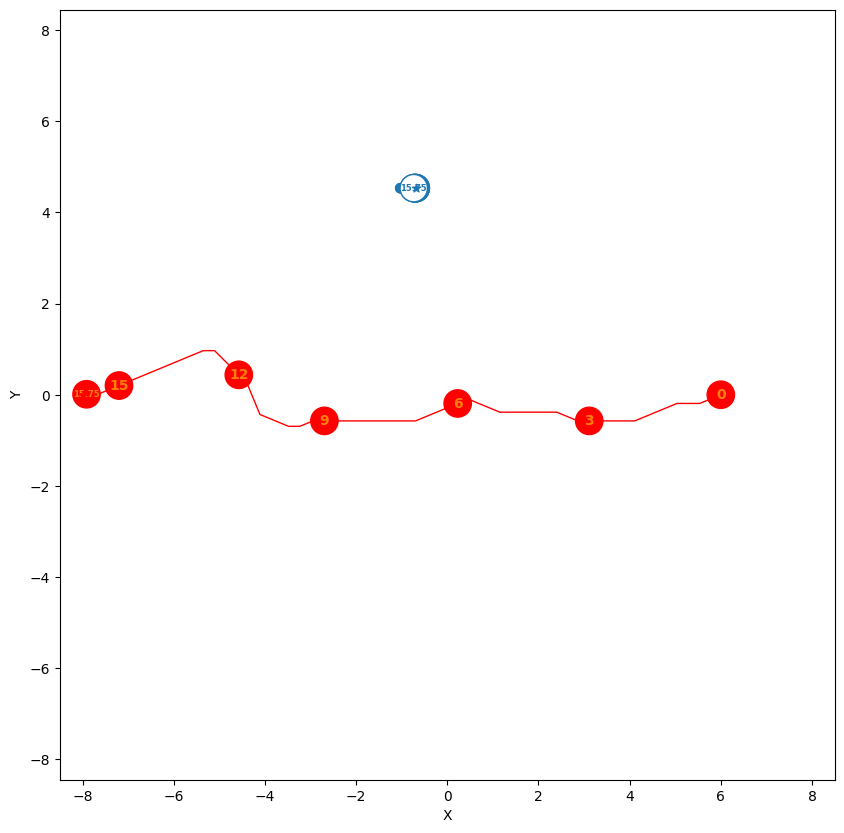

Average time per episode: 0.86 seconds
Total time for 5 episodes: 4.31 seconds


In [14]:
n_episodes = 5
env_params["n_humans"] = 1
env = SocialNav(**env_params)
# Simulate some episodes
episode_simulation_times = np.empty((n_episodes,))
for i in range(n_episodes):
    done = False
    episode_start_time = time.time()
    state, reset_key, obs, info = env.reset(reset_key)
    all_states = np.array([state])
    while not done:
        # action = jnp.array([0.,1.]) # Move north
        action, policy_key, _ = policy.act(policy_key, obs, info, final_model_params, 0.)
        state, obs, info, reward, done = env.step(state,info,action) 
        all_states = np.vstack((all_states, [state]))
    episode_simulation_times[i] = round(time.time() - episode_start_time,2)
    all_states = device_get(all_states) # Transfer data from GPU to CPU for plotting
    print(f"Episode {i} ended - Execution time {episode_simulation_times[i]} seconds - Plotting trajectory...")
    ## Plot episode trajectory
    figure, ax = plt.subplots(figsize=(10,10))
    ax.axis('equal')
    plot_trajectory(ax, all_states, info['humans_goal'], info['robot_goal'])
    for k in range(0,len(all_states),int(3/env_params['robot_dt'])):
        plot_state(ax, k*env_params['robot_dt'], all_states[k], env_params['humans_policy'], info['current_scenario'], info["humans_parameters"][:,0], env.robot_radius)
    # plot last state
    plot_state(ax, (len(all_states)-1)*env_params['robot_dt'], all_states[len(all_states)-1], env_params['humans_policy'], info['current_scenario'], info["humans_parameters"][:,0], env.robot_radius)
    plt.show()
# Print simulation times
print(f"Average time per episode: {round(np.mean(episode_simulation_times),2)} seconds")
print(f"Total time for {n_episodes} episodes: {round(np.sum(episode_simulation_times),2)} seconds")